<a href="https://colab.research.google.com/github/shashi-punu29/Advance-Regression-Assignment/blob/main/Copy_of_Deployment2_Deploy_Machine_Learning_Model_Using_TensorFlow_2_0_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

Note: You can run this example right now in a Jupyter-style notebook, no setup required!  Just click "Run in Google Colab"

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
</tr></table></div>

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/serving/).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb).

This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [ ]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [ ]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
TensorFlow version: 2.7.0


## Create your model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
train_images[0].shape

(28, 28)

In [ ]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

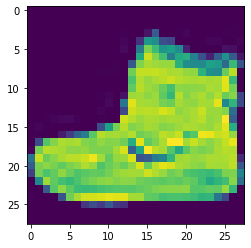

In [ ]:
plt.imshow(train_images[0].reshape(28,28)) # Heatmap
plt.show()

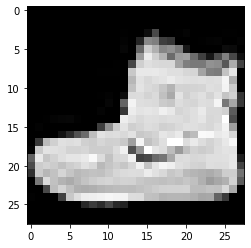

In [ ]:
plt.imshow(train_images[0].reshape(28,28), cmap='gray')
plt.show()

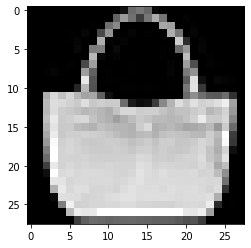

In [ ]:
plt.imshow(train_images[100].reshape(28,28),cmap='gray')
plt.show()

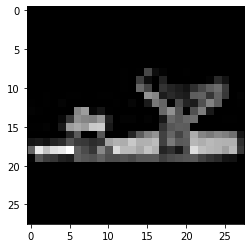

In [ ]:
plt.imshow(train_images[59999].reshape(28,28),cmap='gray')
plt.show()

# Labels

Each training and test example is assigned to one of the following labels:

0 T-shirt/top

1 Trouser

2 Pullover

3 Dress

4 Coat

5 Sandal

6 Shirt

7 Sneaker

8 Bag

9 Ankle boot

In [ ]:
train_labels[59999]

5

In [ ]:
# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
train_images[59999]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

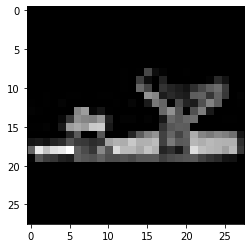

In [ ]:
plt.imshow(train_images[59999].reshape(28,28),cmap='gray')
plt.show()

In [ ]:
train_labels[59999]

5

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
# reshape (60000, 28, 28) to (60000, 28, 28, 1)  for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
test_images.shape

(10000, 28, 28, 1)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


In [ ]:
len(train_images)

60000

In [ ]:
len(train_labels)

60000

In [ ]:
len(test_images)

10000

In [ ]:
len(test_labels)

10000

In [ ]:
plt.style.use('dark_background')

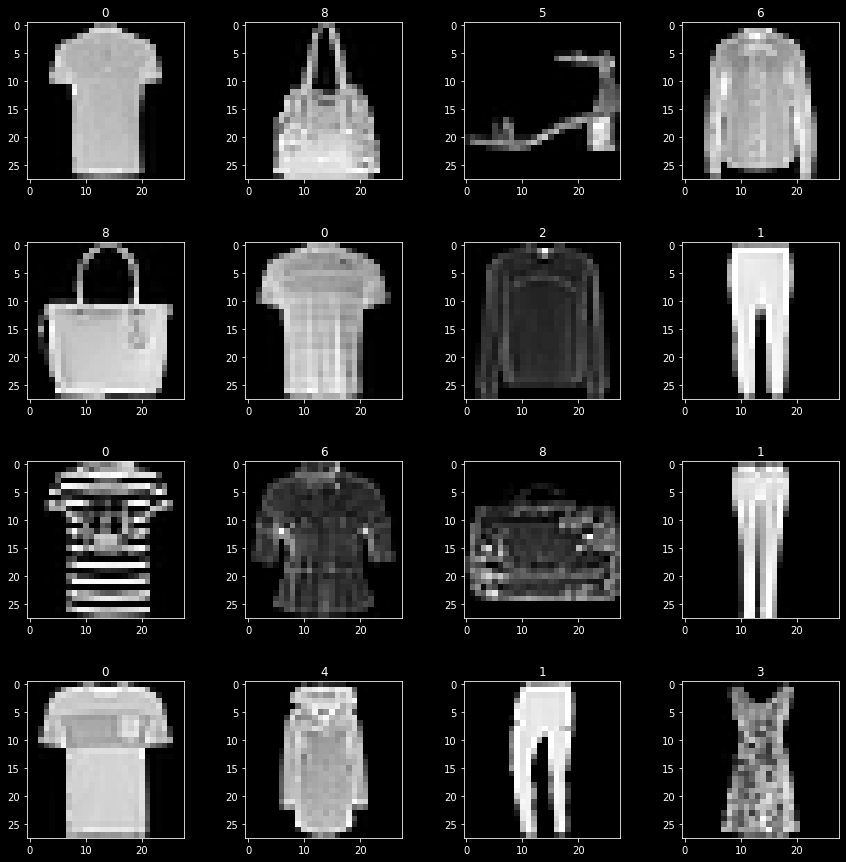

In [ ]:
W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize=(15,15))
axes = axes.ravel()

n_training = len(train_images) # 60000

for i in np.arange(0, L_grid*W_grid):
  index = np.random.randint(0, n_training) # pick a random number
  axes[i].imshow(train_images[index].reshape(28,28),cmap='gray')
  axes[i].set_title(train_labels[index])
plt.subplots_adjust(hspace=0.4);

### Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

# OR as below
# model = keras.models.Sequential()
# model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
# model.add(keras.layers.MaxPooling2D(2,2))
# model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(64, activation='relu'))
# model.add(keras.layers.Dense(10, activation='softmax'))
# model.summary()   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Softmax (Dense)             (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Epoch 1/5
1875/1875 [==============================] - 8s 3ms/step - loss: 0.5421 - accuracy: 0.8131
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3969 - accuracy: 0.8617
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3589 - accuracy: 0.8734
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3375 - accuracy: 0.8797
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.3749 - accuracy: 0.8657

Test accuracy: 0.8657000064849854


## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key


# Lets obtain temporary storage directory
import tempfile

MODEL_DIR = tempfile.gettempdir()

In [ ]:
MODEL_DIR

'/tmp'

In [ ]:
# Lets specify the model version, choose #1 for now
version = 1

In [ ]:
# Lets join the temp model directory with our choosen version number
# The expected result will be '\tmp\version number'
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /tmp/1



In [ ]:
# Lets save the model
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



Saved model:
total 88
drwxr-xr-x 2 root root  4096 Nov 21 17:15 assets
-rw-r--r-- 1 root root  8105 Nov 21 17:24 keras_metadata.pb
-rw-r--r-- 1 root root 72272 Nov 21 17:24 saved_model.pb
drwxr-xr-x 2 root root  4096 Nov 21 17:24 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [ ]:
# Now we can see our saved model 
!saved_model_cli show --dir {export_path} --all
# MetaGraphDef - are my trained model, trained weights and so on. It contains all the dataflow graph, plus
#  the associated variables, assets and signatures
# Signature - is a set of inputs to and outputs from a graph 


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: Te

That tells us a lot about our model!  In this case we just trained our model, so we already know the inputs and outputs, but if we didn't this would be important information.  It doesn't tell us everything, like the fact that this is grayscale image data for example, but it's a great start.

## Serve your model with TensorFlow Serving

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

# These lines looks a bit strange, but it is a standard way.
# Here we basically add our tensorflow-model-server package to our list of packages. 
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update 

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://security.

### Install TensorFlow Serving

This is all you need - one command line!

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.7.0).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

**Congratulations!!! Now we have successfully loaded a servable version of our model.**

## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28), cmap='gray')
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

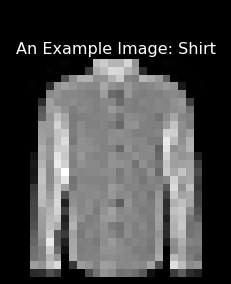

In [ ]:
import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


### Make REST requests

#### Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

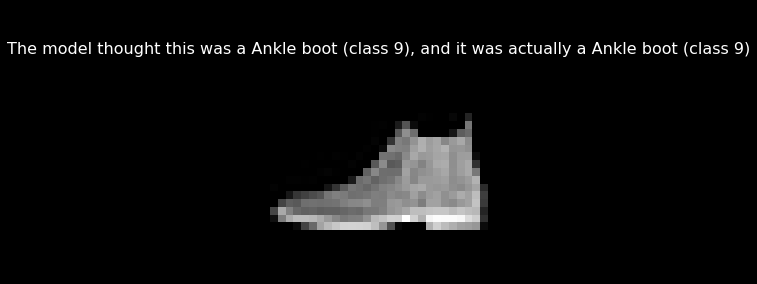

In [ ]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.

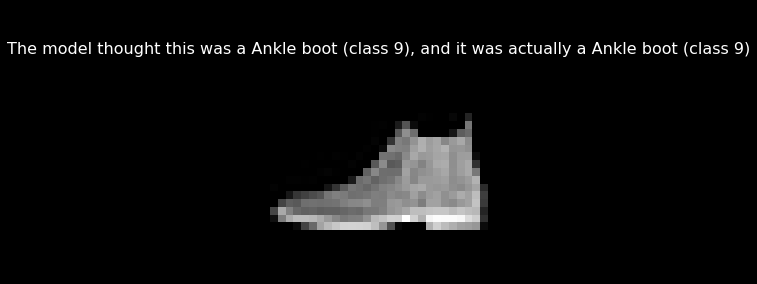

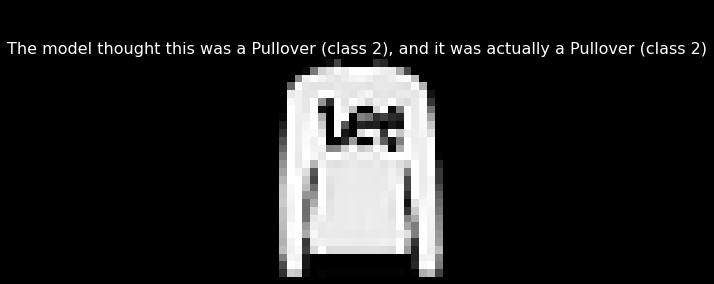

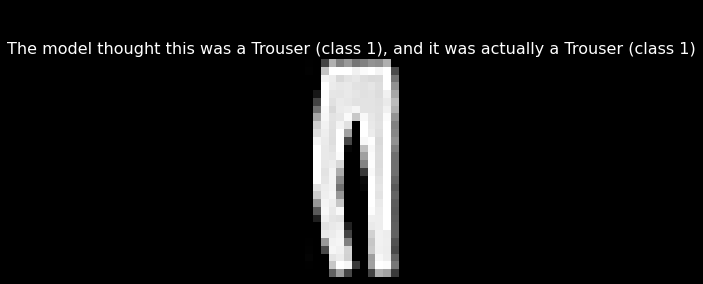

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))

# **Happy Learning**